In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
hypothesises = pd.read_csv('hypothesis.csv')

В первую очередь посмотрим сколько у нас гипотез и оттуда решим, какие методы будем применять для их сравнения.

In [3]:
hypothesises

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Применим фреймворки ICE и RICE. Начнем c ICE

In [4]:
hypothesises['ice_score'] = hypothesises['Impact'] *  hypothesises['Confidence'] / hypothesises['Efforts']
hypothesises[['Hypothesis', 'ice_score']]

,Hypothesis,ice_score
0,"Добавить два новых канала привлечения трафика,...",13.333333
1,"Запустить собственную службу доставки, что сок...",2.000000
2,Добавить блоки рекомендаций товаров на сайт ин...,7.000000
3,"Изменить структура категорий, что увеличит кон...",1.125000
4,"Изменить цвет фона главной страницы, чтобы уве...",1.000000
5,"Добавить страницу отзывов клиентов о магазине,...",1.333333
6,Показать на главной странице баннеры с актуаль...,8.000000
7,Добавить форму подписки на все основные страни...,11.200000
8,"Запустить акцию, дающую скидку на товар в день...",16.200000


Есть явные лидеры - это гипотезы 0, 8 и 9

In [5]:
hypothesises['rice_score'] = hypothesises['Reach'] * hypothesises['Impact'] *  hypothesises['Confidence'] / hypothesises['Efforts']
hypothesises[['Hypothesis', 'rice_score']]

,Hypothesis,rice_score
0,"Добавить два новых канала привлечения трафика,...",40.0
1,"Запустить собственную службу доставки, что сок...",4.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
3,"Изменить структура категорий, что увеличит кон...",9.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
6,Показать на главной странице баннеры с актуаль...,40.0
7,Добавить форму подписки на все основные страни...,112.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2


Когда добавили параметр с охватом, то уже гипотезы 1, 3, 7 и 8 наиболее предпочтительны. Но более всего выделяется 8 гипотеза. Она же входила в тройку по важности во фреймворке ICE. Ее и проверим в первую очередь.

Теперь посмотрим на результаты A/B-теста 

In [6]:
visitors = pd.read_csv('visitors.csv')
orders = pd.read_csv('orders.csv')

In [7]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В первую очередь построим графики кумулятивной выручки по группам. Начнем с перевода даты к нужному типу данных

In [11]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Создаем массив уникальных пар даты и группы

In [12]:
datesGroups = orders[['date', 'group']].drop_duplicates()

Получаем агрегированные кумулятивные данные по дням заказов и посетителям

In [13]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
.agg({'date': 'max', 'group': 'max', 'transactionId': pd.Series.nunique, 'visitorId': pd.Series.nunique, 'revenue': 'sum'}), axis=1).sort_values(by=['date', 'group'])
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
.agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}), axis=1).sort_values(by=['date', 'group'])

Объединим получившиеся данные в одну таблицу

In [14]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


И наконец построим графики кумулятивной выручки по дням и группам  

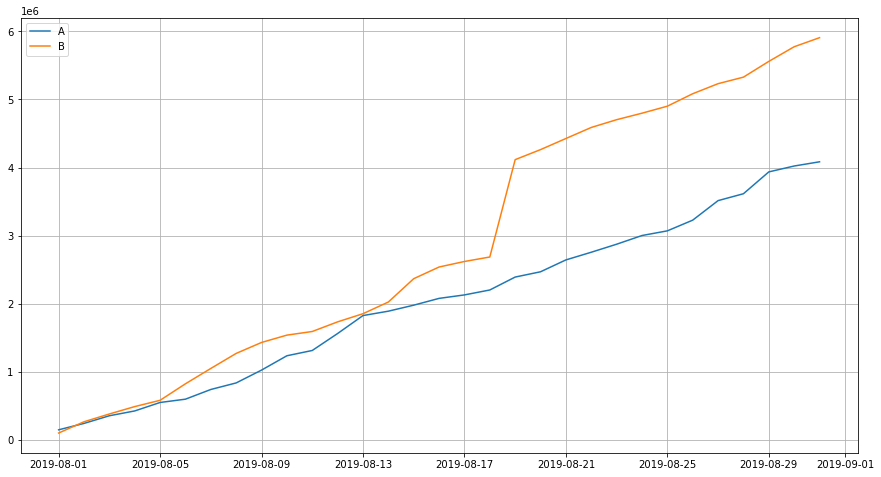

In [15]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]
plt.figure(figsize=(15, 8))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()

Выручки в обеих группах растут, это хороший знак. Однако мы видим, что в определенный момент в группе B выручка резко выросла и продолжила свой постепенный рост.

Теперь посмотрим на график по среднему чеку.

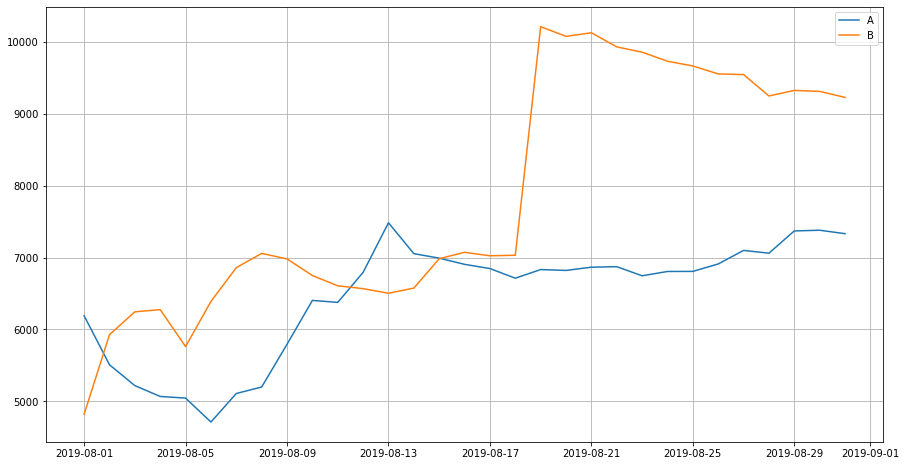

In [16]:
plt.figure(figsize=(15, 8))
plt.grid()
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()

Тут также имеется резкий скачок в определенную дату для группы B. Однако для группы А средний чек слегка увеличивается и начинает стабилизироваться около 7400 у.е., в то время как для группы B средний чек снижается с аномально 10000+ у.е. до 9200 у.е.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

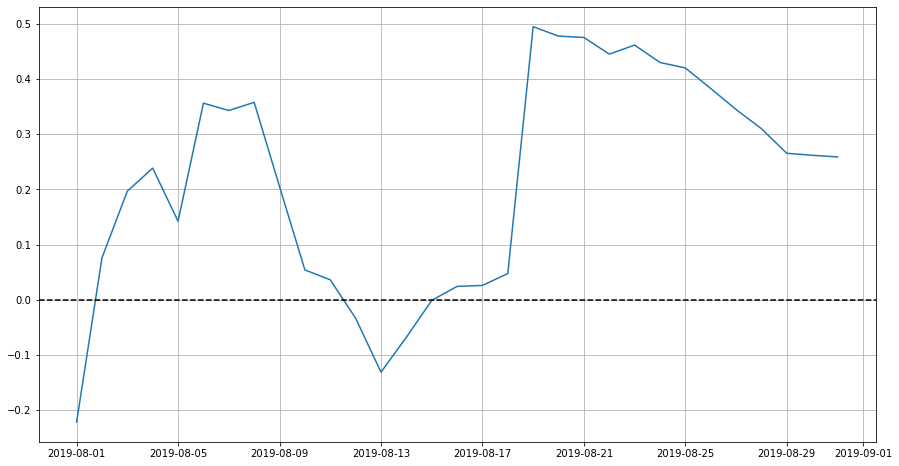

In [17]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(15, 8))
plt.grid()
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')

Видно, что в начале графика былл значительное увеличение и наибольшее увеличение в середине. Наверняка замешаны аномалии, будем это проверять.

Проверим график кумулятивной конверсии по группам

(18109.0, 18140.0, 0.0, 0.04)

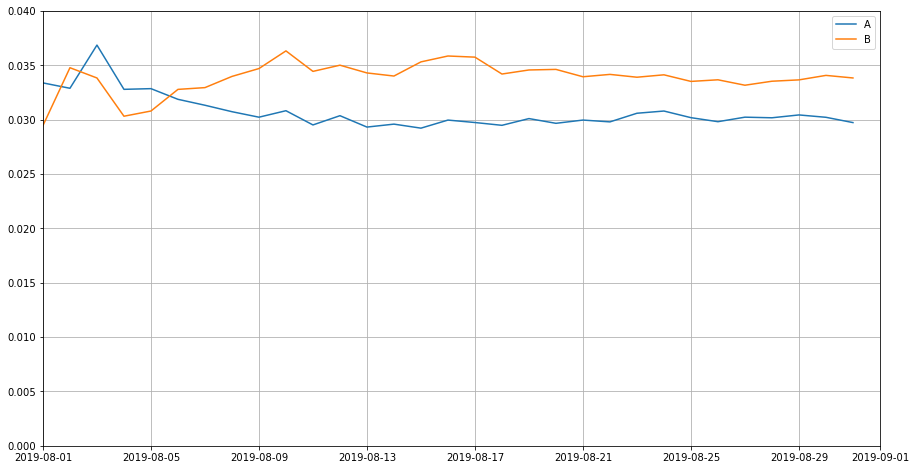

In [18]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']
plt.figure(figsize=(15, 8))
plt.grid()
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-09-01'), 0, 0.040]) 

По графику видно, что конверсии стабилизировались: группа А спустя треть месяца, группа B через полмесяца. У группы А колеблется в районе 3%, у группы B - в районе 3,4%.

А теперь проверим на графике относительного изменения кумулятивной конверсии группы B к группе A

(18109.0, 18140.0, -0.3, 0.3)

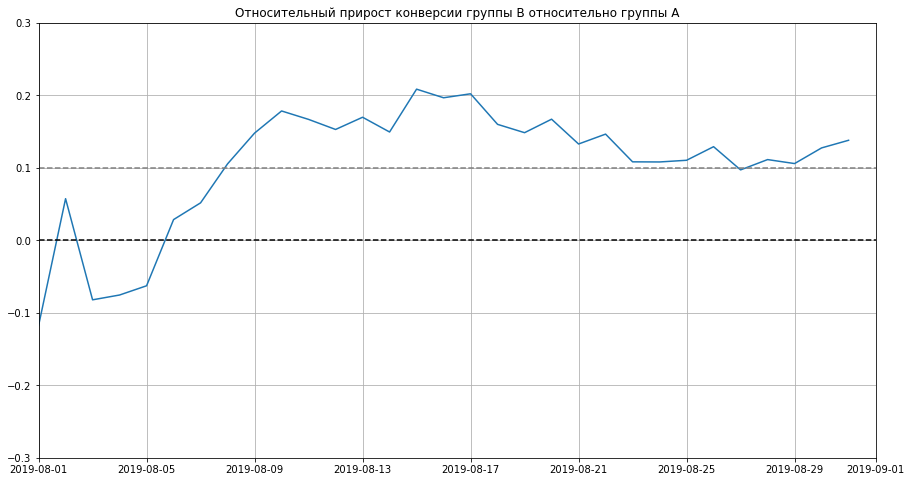

In [19]:
mergedCumulativeConversion = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15, 8))
plt.grid()
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.plot(mergedCumulativeConversion['date'], mergedCumulativeConversion['conversionB']/mergedCumulativeConversion['conversionA']-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-09-01'), -0.3, 0.3]) 

После скачков в первые дни конверсия группы B резко возросла, потом стала постепенно падать, но сейчас снова идет постепенный рост. Видимо, конверсия еще не стабилизировалась. Посмотрим, как изменятся графики, когда избавимся от аномалий.

Построим точечный график количества заказов по пользователям

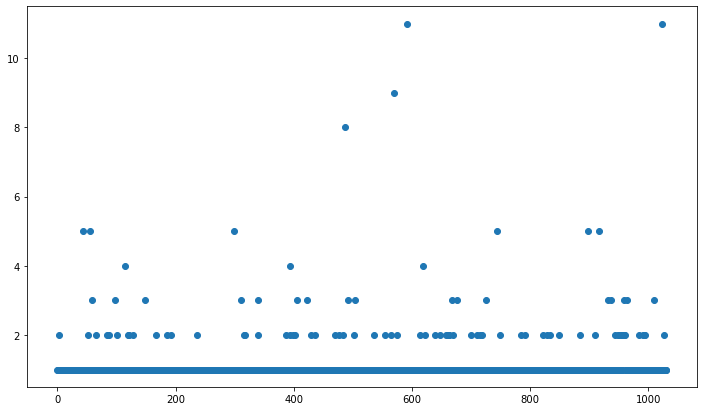

In [20]:
ordersByUsers = orders.drop(['date', 'revenue', 'group'], axis=1).groupby(['visitorId'], as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsers.columns = ['visitorId', 'orders']
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.figure(figsize=(12, 7))
plt.scatter(x_values, ordersByUsers['orders'])

Подавляющее большинство сделало заказ 1 раз. Имеются также определенное кол-во с двумя заказами, но непонятно, насколько их много. Посчитаем по перцентилям.

In [21]:
print(np.percentile(ordersByUsers['orders'], [90, 95, 99]))

[1. 2. 4.]


Не более 5% пользователей делали заказ более двух раз. Разумно будет взять границу аномолии в больше двух покупок.

Аналогично построим точечный график стоимостей заказов.

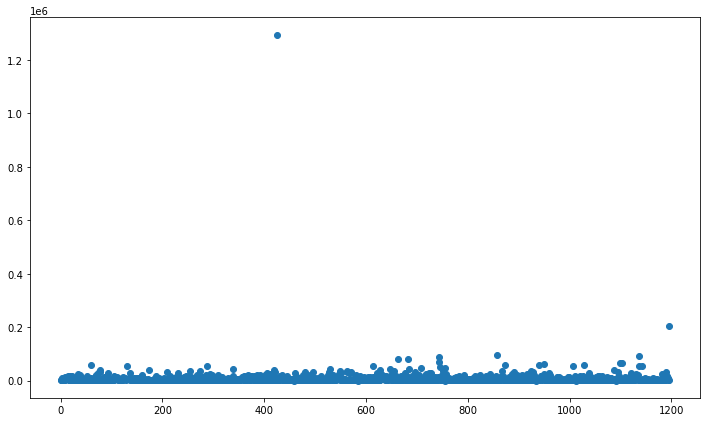

In [22]:
x_values = pd.Series(range(0, len(orders)))
plt.figure(figsize=(12, 7))
plt.scatter(x_values, orders['revenue'])

По графику и не скажешь, где тут примерная граница аномалий из-за наличия явной аномалии в более 1,2 миллиона у.е. Посмотрим по перцентилям

In [23]:
print(np.percentile(orders['revenue'], [90, 95, 96, 99]))

[18168.  28000.  31382.  58233.2]


Не более 5% пользователей совершали покупки на сумму более 28 тыс. у.е. и не более 4% - на сумму более 31382 у.е. Поставим границу аномалий в более, чем в 30 тыс. у.е.  

Подготовим данные для подсчета статистической значимости.

Сначала разберемся с данными по посетителям: 1)построим данные по посетителям на каждый день каждой группы, 2)кумулятивные данные по посетителям на каждый день каждой группы

In [24]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [25]:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ), 
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

Теперь подготовим данные по заказам: 1)построим данные по количеству заказов, их общей сумме на каждый день по группам, 2)кумулятивные данные по количеству заказов, их общей сумме на каждый день по группам

In [26]:
ordersADaily = orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']].groupby(
    ['date'], as_index = False
).agg({'transactionId':pd.Series.nunique, 'revenue': 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']].groupby(
    ['date'], as_index = False
).agg({'transactionId':pd.Series.nunique, 'revenue': 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

In [27]:
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

И наконец объединяем в один большой датафрейм все построенные данные

In [28]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,719,719,719
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,619,1338,1338
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,507,1845,1845
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,717,2562,2562
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,756,3318,3318


Теперь построим данные для пользователей, которые сделали хотя бы один заказ

In [29]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

Теперь подготовим переменные, в которых будет информация и количестве заказов каждого пользователя, в том числе и с нулем заказов

In [30]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        )
    ],
    axis=0
)
sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        )
    ],
    axis=0
)

И наконец посчитаем статистическую значимость различий в конверсии заказов между группами по 'сырым' данным и также относительный прирост конверсии группы B над группой A

In [31]:
print('{0:.3f}'.format(st.mannwhitneyu(sampleA, sampleB)[1]))
print('{0:.3f}'.format(sampleB.mean(sampleB.mean()/sampleA.mean()-1)))

0.500
0.030


p-value равно 0.5, что значительно больше 0.05. Нулевую гипотезу о том, что статистически значимых различий между группами нет, не отвергаем. Это также и говорит, что конверсия группы B превышает конверсию группы А всего на 3%.

Теперь рассчитаем статистическую значимость различий в среднем чеке между группами по 'сырым' данным и также относительный прирост в среднем чеке группы B к группе А

In [32]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group'] == 'A']['revenue'], orders[orders['group'] == 'B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group'] == 'B']['revenue'].mean()/orders[orders['group'] == 'A']['revenue'].mean()-1))

0.365
0.259


p-value 0.365, что говорит нам - нулевая гипотеза о равенстве средних чеков между группами не отвергается. Несмотря на превосходство почти в 26% по среднему чеку группы B над группой A

Подготовим 'очищенные данные': начнем с выделения данных с аномальными кол-во заказов и стоимостью заказа, выявленных ранее.

In [33]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0
)

usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']

In [34]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head()

1099    148427295
18      199603092
928     204675465
23      237748145
684     358944393
Name: visitorId, dtype: int64

In [35]:
abnormalUsers.shape

(62,)

Всего 62 пользователя. Посмотрим, как скажется на данных их отсутствие. Сначала подготовим по группе А

In [36]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders'
        ),
    ],
    axis=0
)

Теперь 'очищенные' данные по группе B

In [37]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsers['orders'])
            ),
            name='orders'
        ),
    ],
    axis=0
)

И наконец посчитаем статистическую значимость различий в конверсии между группами по 'очищенным' данным

In [38]:
print("{0:.3f}".format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.329
0.029


p-value снизился заметно (с 0,500 до 0,329), но все равно значительно выше 0.05. Тем не менее различие в конверсии  уменьшилось всего лишь с 3% до 2.9% 

Теперь рассчитаем статистическую значимость различий в среднем чеке между группами по 'очищенным' данным и также относительные различия в среднем чеке группы B к группе А

In [39]:
print(
    "{0:.3f}".format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        -1
    )
)

0.383
-0.021


p-value только увеличился (с 0.365 до 0.383), что значит еще более уверенно не стоит отвергать нулевую гипотезу о том, что у групп нет статистически значимых различий. И что самое главное - средний чек группы B теперь меньше группы А на 2.1% после избавления от выбросов, которые наоборот давали преимущество группе B на 25,9%.

**Общие выводы**

1) Судя по кумулятивным графикам группа B в какой-то момент и правда заметно вырвалась вперед, но это лишь иллюзия из-за 'аномальной' выручки в определенную дату в середине исследования.

2) После избавления от 'выбросов', можно предположить, что между группами нет значимых различий, поэтому стоит остановить А/B тест. 